<a href="https://colab.research.google.com/github/jazu1412/LOW_CODE_AUTOML_AUTOGLUON/blob/master/TEXT%20CLASSIFICATION/Sentiment_analysis_and_sentence_similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AutoMM for Text - Quick Start



`MultiModalPredictor` can solve problems where the data are either image, text, numerical values, or categorical features.
To get started, we first demonstrate how to use it to solve problems that only contain text. We pick two classical NLP problems for the purpose of demonstration:

- [Sentiment Analysis](https://en.wikipedia.org/wiki/Sentiment_analysis)
- [Sentence Similarity](https://arxiv.org/abs/1910.03940)

Here, we format the NLP datasets as data tables where
the feature columns contain text fields and the label column contain numerical (regression) / categorical (classification) values.
Each row in the table corresponds to one training sample.

In [1]:
!pip install autogluon.multimodal


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 937.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of openxlab to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runti

In [2]:
%matplotlib inline

import numpy as np
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')
np.random.seed(123)

## Sentiment Analysis Task

First, we consider the Stanford Sentiment Treebank ([SST](https://nlp.stanford.edu/sentiment/)) dataset, which consists of movie reviews and their associated sentiment.
Given a new movie review, the goal is to predict the sentiment reflected in the text (in this case a **binary classification**, where reviews are
labeled as 1 if they convey a positive opinion and labeled as 0 otherwise). Let's first load and look at the data,
noting the labels are stored in a column called **label**.

In [3]:
from autogluon.core.utils.loaders import load_pd
train_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/train.parquet')
test_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/dev.parquet')
subsample_size = 1000  # subsample data for faster demo, try setting this to larger values
train_data = train_data.sample(n=subsample_size, random_state=0)
train_data.head(10)

Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/train.parquet | Columns = 2 / 2 | Rows = 67349 -> 67349
Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/sst/dev.parquet | Columns = 2 / 2 | Rows = 872 -> 872


,sentence,label
43787,very pleasing at its best moments,1
16159,", american chai is enough to make you put away...",0
59015,too much like an infomercial for ram dass 's l...,0
5108,a stirring visual sequence,1
67052,cool visual backmasking,1
35938,hard ground,0
49879,"the striking , quietly vulnerable personality ...",1
51591,pan nalin 's exposition is beautiful and myste...,1
56780,wonderfully loopy,1
28518,"most beautiful , evocative",1


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['label'].plot(kind='hist', bins=20, title='label')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='index', y='label', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['label'].plot(kind='line', figsize=(8, 4), title='label')
plt.gca().spines[['top', 'right']].set_visible(False)

Above the data happen to be stored in the [Parquet](https://databricks.com/glossary/what-is-parquet) format, but you can also directly `load()` data from a [CSV](https://en.wikipedia.org/wiki/Comma-separated_values) file or other equivalent formats.
While here we load files from [AWS S3 cloud storage](https://docs.aws.amazon.com/AmazonS3/latest/dev/Welcome.html), these could instead be local files on your machine.
After loading, `train_data` is simply a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html),
where each row represents a different training example.

### Training

To ensure this tutorial runs quickly, we simply call `fit()` with a subset of 1000 training examples and limit its runtime to approximately 1 minute.
To achieve reasonable performance in your applications, you are recommended to set much longer `time_limit` (eg. 1 hour), or do not specify `time_limit` at all (`time_limit=None`).

In [4]:
!pip uninstall -y torchaudio
!pip install torchaudio

Found existing installation: torchaudio 2.4.0+cu121
Uninstalling torchaudio-2.4.0+cu121:
  Successfully uninstalled torchaudio-2.4.0+cu121
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.1/797.1 MB 787.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.4/209.4 MB 5.9 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.1
    Uninstalling triton-2.3.1:
      Successfully uninstalled triton-2.3.1
  Attempting uninstall: nvidia-cudnn-cu12
    Found existing installation: nvidia-cudnn-cu12 8.9.2.26
    Uninstalling nvidia-cudnn-cu12-8.9.2.26:
      Successfully uninstalled nvidia-cudnn-cu12-8.9.2.26
  Attempting uninstall: torch
    Found existing installation: torch 2.3.1
    Uninstalling torch-2.3.1:
      Successfully uninstalled torch-2.3.1
ERROR: pip's dependency resolver does

In [2]:
!pip install --upgrade torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 40.2 MB/s eta 0:00:00
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.18.1
    Uninstalling torchvision-0.18.1:
      Successfully uninstalled torchvision-0.18.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
autogluon-multimodal 1.1.1 requires torch<2.4,>=2.2, but you have torch 2.4.1 which is incompatible.
autogluon-multimodal 1.1.1 requires torchvision<0.19.0,>=0.16.0, but you have torchvision 0.19.1 which is incompatible.


In [4]:
from autogluon.multimodal import MultiModalPredictor
import uuid
model_path = f"./tmp/{uuid.uuid4().hex}-automm_sst"
predictor = MultiModalPredictor(label='label', eval_metric='acc', path=model_path)
predictor.fit(train_data, time_limit=180)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Pytorch Version:    2.4.1+cu121
CUDA Version:       CUDA is not available
Memory Avail:       10.21 GB / 12.67 GB (80.5%)
Disk Space Avail:   65.05 GB / 107.72 GB (60.4%)
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you have installed tensorboard
    tensorboard --logdir /content/tmp/c0cd5cd11703

config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

GPU Count: 0
GPU Count to be Used: 0

INFO: GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: 
  | Name              | Type                         | Params | Mode 
---------------------------------------------------------------------------
0 | model             | HFAutoModelForTextPrediction | 108 M  | train
1 | validation_metric | MulticlassAccuracy           | 0      | train
2 | loss_func         | CrossEntropyLoss             | 0      | train
---------------------------------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
435.573   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 3: 'val_acc' reached 0.54500 (best 0.54500), saving model to '/content/tmp/c0cd5cd117034a6db0597b3c8f655028-automm_sst/epoch=0-step=3.ckpt' as top 3
INFO: Time limit reached. Elapsed time is 0:03:42. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/tmp/c0cd5cd117034a6db0597b3c8f655028-automm_sst")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




Above we specify that: the column named **label** contains the label values to predict, AutoGluon should optimize its predictions for the accuracy evaluation metric,
trained models should be saved in the **automm_sst** folder, and training should run for around 60 seconds.

### Evaluation

After training, we can easily evaluate our predictor on separate test data formatted similarly to our training data.

In [5]:
test_score = predictor.evaluate(test_data)
print(test_score)

Predicting: |          | 0/? [00:00<?, ?it/s]

{'acc': 0.5103211009174312}


By default, `evaluate()` will report the evaluation metric previously specified, which is `accuracy` in our example. You may also specify additional metrics, e.g. F1 score, when calling evaluate.

In [6]:
test_score = predictor.evaluate(test_data, metrics=['acc', 'f1'])
print(test_score)

Predicting: |          | 0/? [00:00<?, ?it/s]

{'acc': 0.5103211009174312, 'f1': 0.6613798572561458}


### Prediction

And you can easily obtain predictions from these models by calling `predictor.predict()`.

In [7]:
sentence1 = "it's a charming and often affecting journey."
sentence2 = "It's slow, very, very, very slow."
predictions = predictor.predict({'sentence': [sentence1, sentence2]})
print('"Sentence":', sentence1, '"Predicted Sentiment":', predictions[0])
print('"Sentence":', sentence2, '"Predicted Sentiment":', predictions[1])

Predicting: |          | 0/? [00:00<?, ?it/s]

"Sentence": it's a charming and often affecting journey. "Predicted Sentiment": 1
"Sentence": It's slow, very, very, very slow. "Predicted Sentiment": 0


For classification tasks, you can ask for predicted class-probabilities instead of predicted classes.

In [8]:
probs = predictor.predict_proba({'sentence': [sentence1, sentence2]})
print('"Sentence":', sentence1, '"Predicted Class-Probabilities":', probs[0])
print('"Sentence":', sentence2, '"Predicted Class-Probabilities":', probs[1])

Predicting: |          | 0/? [00:00<?, ?it/s]

"Sentence": it's a charming and often affecting journey. "Predicted Class-Probabilities": [0.34515423 0.6548457 ]
"Sentence": It's slow, very, very, very slow. "Predicted Class-Probabilities": [0.5155579  0.48444217]


We can just as easily produce predictions over an entire dataset.

In [9]:
test_predictions = predictor.predict(test_data)
test_predictions.head()

Predicting: |          | 0/? [00:00<?, ?it/s]

,label
0,1
1,1
2,1
3,1
4,0


### Save and Load

The trained predictor is automatically saved at the end of `fit()`, and you can easily reload it.

```{warning}

`MultiModalPredictor.load()` uses `pickle` module implicitly, which is known to be insecure. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling. Never load data that could have come from an untrusted source, or that could have been tampered with. **Only load data you trust.**

```

In [10]:
loaded_predictor = MultiModalPredictor.load(model_path)
loaded_predictor.predict_proba({'sentence': [sentence1, sentence2]})

Load pretrained checkpoint: /content/tmp/c0cd5cd117034a6db0597b3c8f655028-automm_sst/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[0.34515423, 0.6548457 ],
       [0.5155579 , 0.48444217]], dtype=float32)

You can also save the predictor to any location by calling `.save()`.

In [11]:
new_model_path = f"./tmp/{uuid.uuid4().hex}-automm_sst"
loaded_predictor.save(new_model_path)
loaded_predictor2 = MultiModalPredictor.load(new_model_path)
loaded_predictor2.predict_proba({'sentence': [sentence1, sentence2]})

Load pretrained checkpoint: /content/tmp/6526aec3ea24489ba04428a226352db8-automm_sst/model.ckpt


Predicting: |          | 0/? [00:00<?, ?it/s]

array([[0.34515423, 0.6548457 ],
       [0.5155579 , 0.48444217]], dtype=float32)

### Extract Embeddings



You can also use a trained predictor to extract embeddings that maps each row of the data table to an embedding vector extracted from intermediate neural network representations of the row.

In [12]:
embeddings = predictor.extract_embedding(test_data)
print(embeddings.shape)

Predicting: |          | 0/? [00:00<?, ?it/s]

(872, 768)


Here, we use TSNE to visualize these extracted embeddings. We can see that there are two clusters corresponding to our two labels, since this network has been trained to discriminate between these labels.

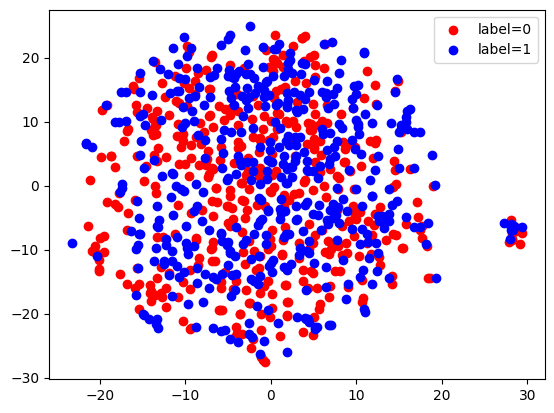

In [13]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, random_state=123).fit_transform(embeddings)
for val, color in [(0, 'red'), (1, 'blue')]:
    idx = (test_data['label'].to_numpy() == val).nonzero()
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], c=color, label=f'label={val}')
plt.legend(loc='best')

## Sentence Similarity Task

Next, let's use MultiModalPredictor to train a model for evaluating how semantically similar two sentences are.
We use the [Semantic Textual Similarity Benchmark](https://paperswithcode.com/dataset/sts-benchmark) dataset for illustration.

In [14]:
sts_train_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sts/train.parquet')[['sentence1', 'sentence2', 'score']]
sts_test_data = load_pd.load('https://autogluon-text.s3-accelerate.amazonaws.com/glue/sts/dev.parquet')[['sentence1', 'sentence2', 'score']]
sts_train_data.head(10)

Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/sts/train.parquet | Columns = 4 / 4 | Rows = 5749 -> 5749
Loaded data from: https://autogluon-text.s3-accelerate.amazonaws.com/glue/sts/dev.parquet | Columns = 4 / 4 | Rows = 1500 -> 1500


,sentence1,sentence2,score
0,A plane is taking off.,An air plane is taking off.,5.00
1,A man is playing a large flute.,A man is playing a flute.,3.80
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,3.80
3,Three men are playing chess.,Two men are playing chess.,2.60
4,A man is playing the cello.,A man seated is playing the cello.,4.25
5,Some men are fighting.,Two men are fighting.,4.25
6,A man is smoking.,A man is skating.,0.50
7,The man is playing the piano.,The man is playing the guitar.,1.60
8,A man is playing on a guitar and singing.,A woman is playing an acoustic guitar and sing...,2.20
9,A person is throwing a cat on to the ceiling.,A person throws a cat on the ceiling.,5.00


from matplotlib import pyplot as plt
_df_5['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='index', y='score', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['index']
  ys = series['score']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('score')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_10['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_11['score'].plot(kind='line', figsize=(8, 4), title='score')
plt.gca().spines[['top', 'right']].set_visible(False)

In this data, the column named **score** contains numerical values (which we'd like to predict) that are human-annotated similarity scores for each given pair of sentences.

In [15]:
print('Min score=', min(sts_train_data['score']), ', Max score=', max(sts_train_data['score']))

Min score= 0.0 , Max score= 5.0


Let's train a regression model to predict these scores. Note that we only need to specify the label column and AutoGluon automatically determines the type of prediction problem and an appropriate loss function. Once again, you should increase the short `time_limit` below to obtain reasonable performance in your own applications.

In [16]:
sts_model_path = f"./tmp/{uuid.uuid4().hex}-automm_sts"
predictor_sts = MultiModalPredictor(label='score', path=sts_model_path)
predictor_sts.fit(sts_train_data, time_limit=60)

=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP PREEMPT_DYNAMIC Thu Jun 27 21:05:47 UTC 2024
CPU Count:          2
Pytorch Version:    2.4.1+cu121
CUDA Version:       CUDA is not available
Memory Avail:       7.70 GB / 12.67 GB (60.8%)
Disk Space Avail:   63.78 GB / 107.72 GB (59.2%)
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and label-values can't be converted to int).
	Label info (max, min, mean, stddev): (5.0, 0.0, 2.701, 1.4644)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during Predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression', 'quantile'])

AutoMM starts to create your model. ✨✨✨

To track the learning progress, you can open a terminal and launch Tensorboard:
    ```shell
    # Assume you ha

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Time limit reached. Elapsed time is 0:01:04. Signaling Trainer to stop.


Validation: |          | 0/? [00:00<?, ?it/s]

AutoMM has created your model. 🎉🎉🎉

To load the model, use the code below:
    ```python
    from autogluon.multimodal import MultiModalPredictor
    predictor = MultiModalPredictor.load("/content/tmp/f965d06720034d02bf93501eeabfd09f-automm_sts")
    ```

If you are not satisfied with the model, try to increase the training time, 
adjust the hyperparameters (https://auto.gluon.ai/stable/tutorials/multimodal/advanced_topics/customization.html),
or post issues on GitHub (https://github.com/autogluon/autogluon/issues).




We again evaluate our trained model's performance on separate test data. Below we choose to compute the following metrics: RMSE, Pearson Correlation, and Spearman Correlation.

In [17]:
test_score = predictor_sts.evaluate(sts_test_data, metrics=['rmse', 'pearsonr', 'spearmanr'])
print('RMSE = {:.2f}'.format(test_score['rmse']))
print('PEARSONR = {:.4f}'.format(test_score['pearsonr']))
print('SPEARMANR = {:.4f}'.format(test_score['spearmanr']))

Predicting: |          | 0/? [00:00<?, ?it/s]

RMSE = 1.45
PEARSONR = 0.3313
SPEARMANR = 0.3112


Let's use our model to predict the similarity score between a few sentences.

In [18]:
sentences = ['The child is riding a horse.',
             'The young boy is riding a horse.',
             'The young man is riding a horse.',
             'The young man is riding a bicycle.']

score1 = predictor_sts.predict({'sentence1': [sentences[0]],
                                'sentence2': [sentences[1]]}, as_pandas=False)

score2 = predictor_sts.predict({'sentence1': [sentences[0]],
                                'sentence2': [sentences[2]]}, as_pandas=False)

score3 = predictor_sts.predict({'sentence1': [sentences[0]],
                                'sentence2': [sentences[3]]}, as_pandas=False)
print(score1, score2, score3)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

2.5426636 2.6705198 2.4033961


Although the `MultiModalPredictor` currently supports classification and regression tasks, it can directly be used for
many NLP tasks if you properly format them into a data table. Note that there can be many text columns in this data table.
Refer to the [MultiModalPredictor documentation](../../../../api/autogluon.multimodal.MultiModalPredictor.fit.rst) to see all available methods/options.

Unlike `TabularPredictor` which trains/ensembles different types of models,
`MultiModalPredictor` focuses on selecting and finetuning deep learning based models.
Internally, it integrates with [timm](https://github.com/rwightman/pytorch-image-models) , [huggingface/transformers](https://github.com/huggingface/transformers),
[openai/clip](https://github.com/openai/CLIP) as the model zoo.

## Other Examples

You may go to [AutoMM Examples](https://github.com/autogluon/autogluon/tree/master/examples/automm) to explore other examples about AutoMM.

## Customization
To learn how to customize AutoMM, please refer to [Customize AutoMM](../advanced_topics/customization.ipynb).